# Homework 4

### Jingheng Huan
Netid: jh730

In [113]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
%matplotlib inline 

## Here is how to load and display the Chinese equivalent to MNIST

Data has been collected by K. Nazarpour and M. Chen at Newcastle university:
https://data.ncl.ac.uk/articles/dataset/Handwritten_Chinese_Numbers/10280831/1
Preprocessing was done by Gabriel Preda:
https://www.kaggle.com/data/174582

In [114]:
# if you have problems with the visualization of the Chinese characters use mplfont
# from https://github.com/Clarmy/mplfonts
# pip install mplfonts
# mplfonts init

# if you have problems with displaying minus signs in the exponents of numbers, uncomment the next two lines
from mplfonts import use_font
use_font('Noto Serif CJK SC')

In [115]:
# loading images and labels 
with open('X.npy', 'rb') as np_file:
    X = np.load(np_file)

with open('y.npy', 'rb') as np_file:
    y = np.load(np_file)    

# loading dictionaries to display numerical values and characters    
import json
with open('value_dict.json','r') as json_file:
    value_dict = json.load(json_file)
    
with open('char_dict.json','r') as json_file:
    char_dict = json.load(json_file)    
    
number_char = len(char_dict)
print('number of classes:', number_char)    

number of classes: 15


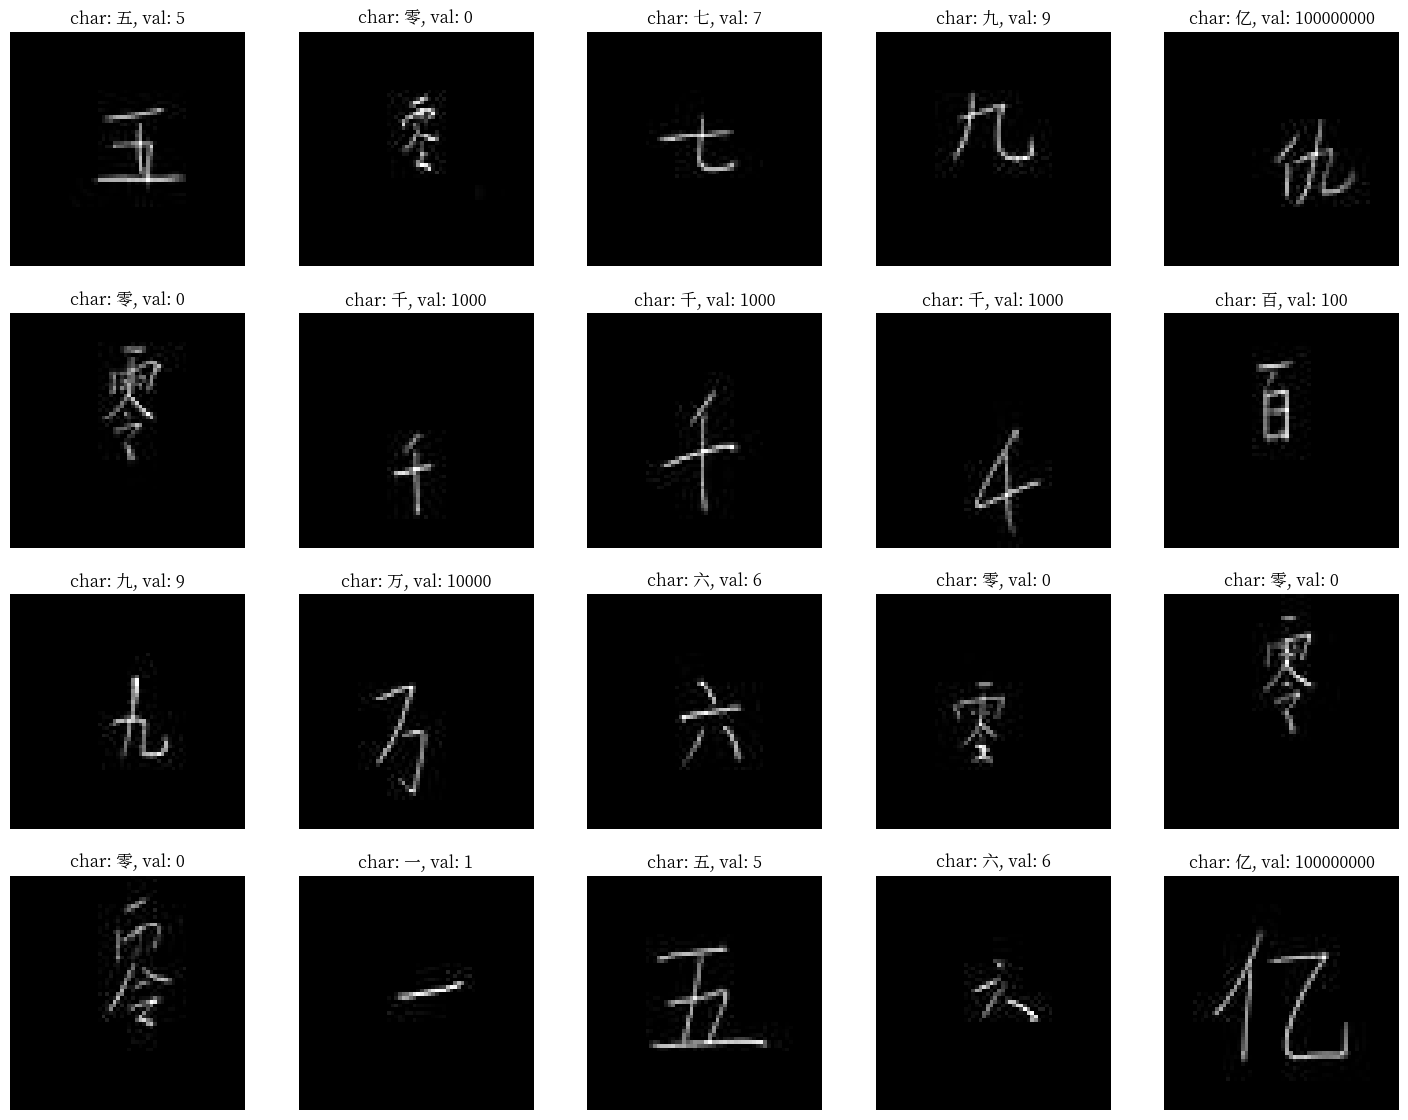

In [116]:
# preview the images
plt.figure(figsize=(18,14))

for i in range(20):  
    plt.subplot(4, 5, i+1)
    plt.imshow(X[i].reshape((64,64)),cmap='gray')
    key = str(y[i])
    plt.title('char: {}, val: {}'.format(char_dict[key],value_dict[key]))
    plt.axis('off')
plt.show()

In [117]:
# this array can be used for labeling the confusion matrix using seaborn
axis_labels = [char_dict['0'], char_dict['1'], char_dict['2'], char_dict['3'], char_dict['4'],
               char_dict['5'], char_dict['6'], char_dict['7'], char_dict['8'], char_dict['9'],
               char_dict['10'], char_dict['11'], char_dict['12'], char_dict['13'], char_dict['14'],
              ]
# you might also want to use: plt.yticks(rotation=0) 

## 1) Chinese MNIST, classical computer vision

**(5 points)**

The aim of this exercise is to identify hand written Chinese characters representing numbers. And we do this the classical, pre-neural network way of computer vision:  In part a) and b) we extract some meaningful features from each image. In part c) we train a random forest to use these features to do the classification.

**a)**  The features we want to extract are the parameters of the three most occupied lines of the image, extracted with a Hough transform. We first do this for a single image which you obtain by reshaping the first row of X into an image with 64 by 64 pixels. Apply an Otsu binarization to this image and display both original and binarized version.

Next, do a Hough transformation of the image with 360 tested angles (use a shifted range: *np.linspace( 0.1, np.pi+0.1 , 360, endpoint=False)* ). Then use *hough_line_peaks* with a minimal distance of 7, a minimal angle of 40, a threshold of 0 and a number of peaks of 3 to identify the three most occupied lines in the image. Draw those lines into a binarized version of the image.   
(*1 point*) 

**b)**  Copy *preview the images* cell from above and modify it to draw the three most occupied lines into the first 20 images of the dataset. (*0.5 points*) 

Then create a new data matrix to use with the random forest classifier: *X_new*,  which has a row for each image and 9 columns. The first three columns are the occupancies  of the 3 lines, the second three are their angles, and the third three are their distances. (*1.5 points*)  

**c)**  Do a 0.7/0.3 train/test split with *X_new* and *y*. Train a random forest classifier using 500 estimators.  Make a prediction for the test data, measure the accuracy on the test data and plot the confusion matrix. (*2 points*)

**ANSWER**

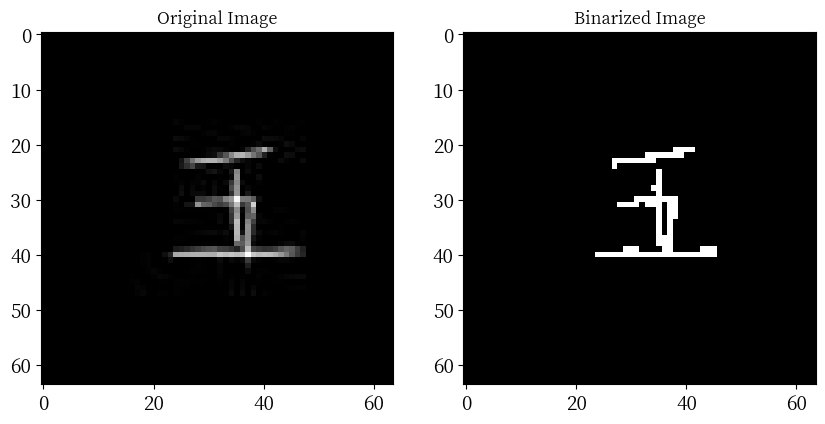

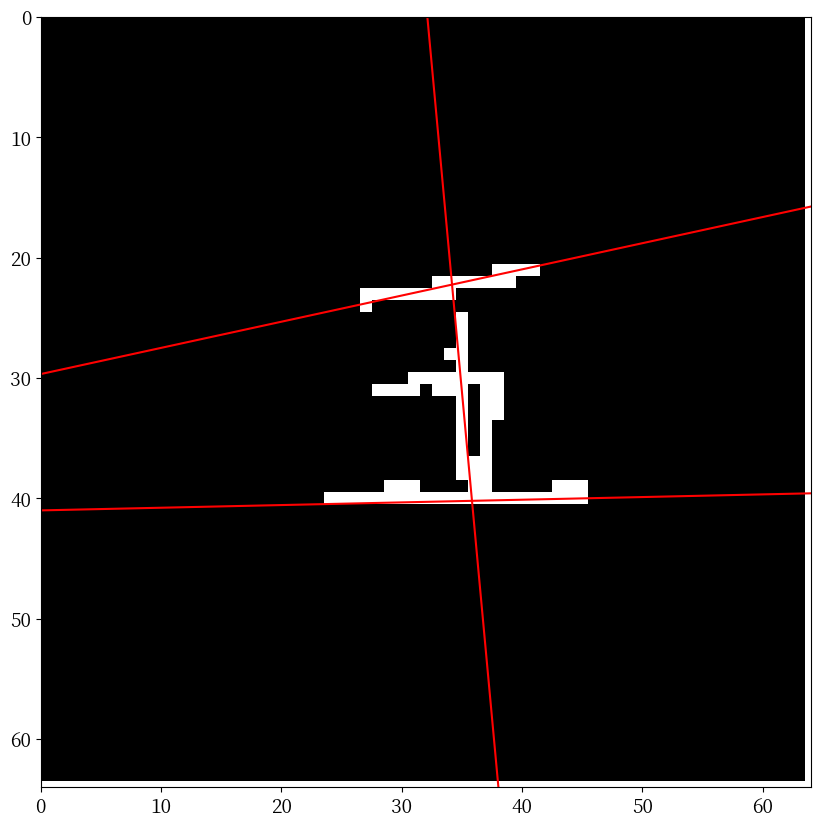

In [118]:
# (a)
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, transform

image = X[0].reshape(64, 64)

# Otsu binarization
threshold = filters.threshold_otsu(image)
binary_image = image > threshold

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(binary_image, cmap='gray')
axes[1].set_title('Binarized Image')
plt.show()

# Hough transformation
h, theta, d = transform.hough_line(binary_image, np.linspace(0.1, np.pi+0.1, 360, endpoint=False))

# Identify the three most occupied lines
peaks, angles, dists = transform.hough_line_peaks(h, theta, d, min_distance=7, min_angle=40, threshold=0, num_peaks=3)

# Draw these lines on the binarized image
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(binary_image, cmap='gray')

for angle, dist in zip(angles, dists):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - binary_image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax.plot((0, binary_image.shape[1]), (y0, y1), '-r')

plt.xlim((0, binary_image.shape[1]))
plt.ylim((binary_image.shape[0], 0))

plt.show()

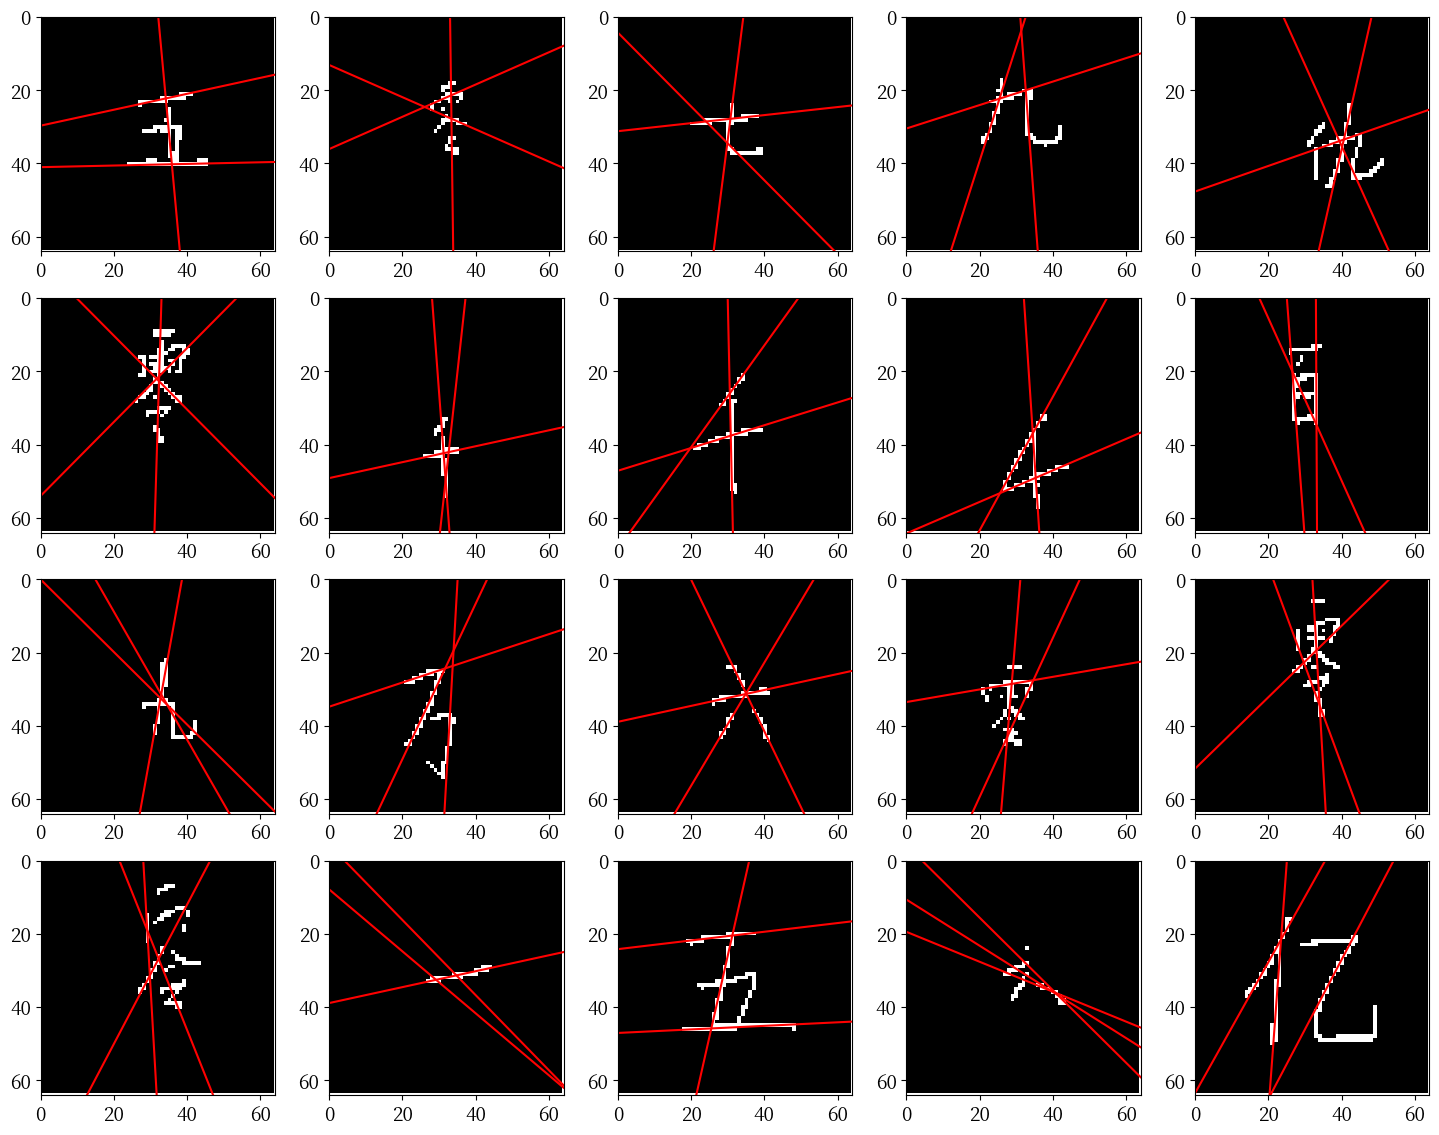

In [119]:
# (b) preview the images
plt.figure(figsize=(18,14))

for i in range(20):  
    plt.subplot(4, 5, i+1)
    image = X[i].reshape((64,64))
    threshold = filters.threshold_otsu(image)
    binary_image = image > threshold
    h, theta, d = transform.hough_line(binary_image, np.linspace(0.1, np.pi+0.1, 360, endpoint=False))
    peaks, angles, dists = transform.hough_line_peaks(h, theta, d, min_distance=7, min_angle=40, threshold=0, num_peaks=3)
    plt.imshow(binary_image, cmap='gray')

    plt.xlim((0, binary_image.shape[1]))
    plt.ylim((binary_image.shape[0], 0))
    
    for angle, dist in zip(angles, dists):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - binary_image.shape[1] * np.cos(angle)) / np.sin(angle)
        plt.plot((0, binary_image.shape[1]), (y0, y1), '-r')
    key = str(y[i])

In [120]:
# (b) create the data matrix
X_new = np.zeros((len(X), 9))

for i in range(len(X)):
    image = X[i].reshape((64,64))
    threshold = filters.threshold_otsu(image)
    binary_image = image > threshold
    h, theta, d = transform.hough_line(binary_image, np.linspace(0.1, np.pi+0.1, 360, endpoint=False))
    peaks, angles, dists = transform.hough_line_peaks(h, theta, d, min_distance=7, min_angle=40, threshold=0, num_peaks=3)
    X_new[i, :3] = peaks
    X_new[i, 3:6] = angles
    X_new[i, 6:] = dists

print(X_new)

[[ 22.  17.  15. ...  41. -32.  29.]
 [ 10.   9.   8. ... -33.  33.  12.]
 [ 19.  13.   8. ...  31.  34.   3.]
 ...
 [ 16.  15.  12. ... -25.  49.  33.]
 [ 14.  14.  11. ...  35.  42. -11.]
 [ 13.   4.   3. ...  37.  14.  -5.]]


Accuracy: 0.7648888888888888


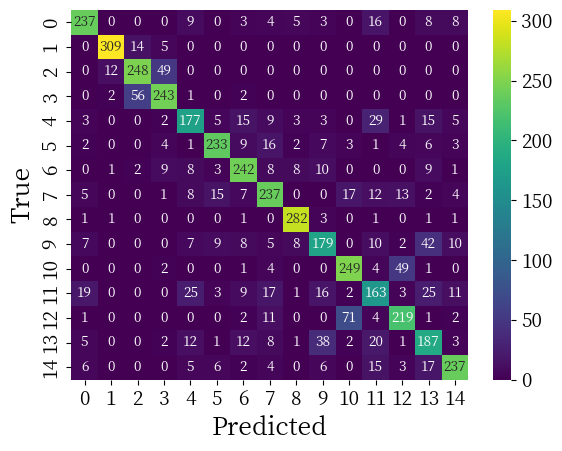

In [121]:
# (c)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

# Train the model
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 2) Tracking an object with the correlation function

**(5 points)**    

Aim of this assignment is to show you how to track a given object using the correlation function.

**a) First you need to collect your raw data** 

Place a small object on a sheet of white paper. Place your camera/smartphone on a solid support such that it only observes the object and is not moving. Take a series of at least ten images, either by using the burst mode on your camera, or by pressing the shutter repeatedly. While you take the images, slowly pull on the sheet of paper such that the object moves through your field of view. The direction and the total length does not matter. But try to have the white paper as a background for the full series. Watch move_2.avi to get an idea how the images could look. 

Next create a movie from your own images: Open Fiji. Click on File - Import - Image Sequence. Choose the directory with your images and open the first one. Fiji opens the Sequence Options window, make sure that Sort Names Numerically is clicked. Press ok and Fiji loads all of your images into one window. With the slider at the bottom of that window you can watch them. 

Press File - Save as - AVI. Choose a Frame rate of 2 fps and Compression JPEG. Press OK and give the movie a name. 
Submit that movie as part of your homework.
(* 2 points*)  

**b) Find the position of the object in the first image by using the correlation function** 

In order to minimize the potential for misunderstandings, I have added the images I have created using my data in the accompanying *HW_correlation_images.pdf*.  

Load the first image, convert it to gray values and invert it; this image is called *gray* in the following. (The inversion is necessary because we do not want to track the white background.) Then cut out a smaller image which contains only the object you want to track (called *obj*). Display both images (see slide Images 1 in the correlation.pdf). (*0.5 point*) 

Compute the correlation (named *result*) between the *gray* and *obj* by using multiplication in Fourier space. Visualize both *result* and a binarization with a threshold of 95 % of the maximum of *result*  (see slide Images 2).
(*1 point*)

The maximum of the correlation is located at the bottom right corner of *obj*. In order to get the center coordinates 
in the *gray* coordinate system you need to shift the position by half of the *obj* dimensions. The following code gives you the row and column position of the maximum:
```python
ind = np.unravel_index(np.argmax(result, axis=None), result.shape)
row = int(ind[0] - obj.shape[0]/2)
col = int(ind[1] - obj.shape[1]/2)
```
Then use *cv2.circle* to draw into *gray* a red, filled point of diameter 10 pixels at the position of the maximum. Remember the x,y convention used in opencv. Display the image. (cf. slide Image 3)  (*0.5 points*) 


**c) Analyze the full sequence of your images.**

Load a copy of the final image of your series. Write a for loop going over all your images and for each compute the correlation with *obj*. Draw for each maximum a circle into your final image. 
After finishing the loop, display your resulting image. (cf. slide Images 4)
(*1 point*) 


**ANSWER**